In [53]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = '/content/gdrive/My Drive/ECE763/'
import numpy as np
import cv2
from scipy.stats import multivariate_normal
from scipy.special import psi, gammaln
from scipy.optimize import fminbound
from sklearn.decomposition import PCA
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

np.random.seed(2)
facetrain= np.load(path+'MyData4/ftrain.npy')
nonfacetrain= np.load(path+'MyData4/nftrain.npy')
facetest= np.load(path+'MyData4/ftest.npy')
nonfacetest= np.load(path+'MyData4/nftest.npy')


Mounted at /content/gdrive


In [0]:
def apply_pca_and_standardize(data,size):
    pca = PCA(n_components=size)
    pca.fit(data)
    data_pca = pca.transform(data)
    scaler = StandardScaler()
    scaler.fit(data_pca)
    data_std = scaler.transform(data_pca)
    return data_std,pca

In [0]:
size = 30
# pca_face = PCA(size)
facetrain_pca,pcaft = apply_pca_and_standardize(facetrain,size) 
nonfacetrain_pca,pcanft = apply_pca_and_standardize(nonfacetrain,size) 
facetest_pca,pcaftest  = apply_pca_and_standardize(facetest,size)
nonfacetest_pca,pcaftrain  = apply_pca_and_standardize(nonfacetest,size)

In [0]:
def fit_t_minimize_cost(E_hi, E_log_hi):
  a = 0
  d = 1000
  while True:
    third = (d-a)/3        
    b = a + third
    c = d - third
    b_cost = fit_t_cost (b, E_hi, E_log_hi)
    c_cost = fit_t_cost (c, E_hi, E_log_hi)
    if b_cost < c_cost:            
      d=c # The new search range is [a,c].
    else:
      a=b # The new search range is [b,d].
    if d-a < 1:
      nu = d # We could have picked a also.
        
      break
  return nu
def fit_t_cost (nu, E_hi, E_log_hi):
  nu_half = nu / 2
  I = E_hi.shape[0]
  val = I * (nu_half*np.log(nu_half) + gammaln(nu_half))
  val = val - (nu_half-1)*np.sum(E_log_hi)
  val = val + nu_half*np.sum(E_hi)
  val = -1 * val
  return val

def fit_t(x,precision):
  I = x.shape[0]
  dataset_mean = np.sum(x,axis=0) / I
  dataset_mean = np.reshape(dataset_mean,(1,dataset_mean.shape[0]))
  mu = dataset_mean
  D = x.shape[1]
  dataset_variance = np.zeros((D, D))
  x_minus_dataset_mean = np.subtract(x, dataset_mean)
  print(x_minus_dataset_mean.shape)
  for i in range(I):
    mat = np.array([x_minus_dataset_mean[i,:]])
    mat = np.matmul(np.transpose(mat),mat)
    dataset_variance= dataset_variance+mat
  dataset_variance = dataset_variance/I
  sig = dataset_variance

  nu = 1000
  iterations = 0
  previous_L = 1000000
  delta = np.zeros([I,1])

  while True:
    x_minus_mu = np.subtract(x,mu)
    temp = np.dot(x_minus_mu,np. linalg. inv(sig))
    for i in range(I):
      delta[i] = np.matmul(np.array([temp[i,:]]),np.transpose(np.array([x_minus_mu[i,:]])))
    nu_plus_delta = nu + delta
    E_hi = (nu + D) / nu_plus_delta
    E_log_hi = psi((nu+D)/2) - np.log(nu_plus_delta/2)

    E_hi_sum = np.sum(E_hi)
    E_hi_times_xi = E_hi*x
    mu = np.sum(E_hi_times_xi,axis=0)/E_hi_sum
    x_minus_mu = np.subtract(x, mu)
    sig = np.zeros((D,D))
    for i in range(I):
      xmm = np.array([x_minus_mu[i,:]])
      sig = sig+E_hi[i]*np.transpose(xmm)*xmm
    sig = sig/E_hi_sum
    nu = fit_t_minimize_cost(E_hi, E_log_hi)


    temp = np.matmul(x_minus_mu,np.linalg.inv(sig))
    for i in range(I):
      delta[i] = np.matmul(np.array([temp[i,:]]),np.transpose(np.array([x_minus_mu[i,:]])))

    L = I * (gammaln((nu+D)/2) - (D/2)*np.log(nu*np.pi) - np.log(np.linalg.det(sig))/2 - gammaln(nu/2))
    s = sum (np.log(1 + delta/nu)) / 2
    L = L - (nu+D)*s
    print(L)
    iterations = iterations + 1;
    print('iternation number:',iterations)       
    if np.abs(L - previous_L) < precision:
    	break
    previous_L = L
  return mu,sig,nu

In [58]:
dimm = 20
Xf = facetrain_pca
precision = 0.001
iterations_count = 500
af,bf,cf = fit_t(Xf,precision)
Xnf = nonfacetrain_pca
anf,bnf,cnf = fit_t(Xnf,precision)

(1000, 30)
[-42516.32742555]
iternation number: 1
[-42516.32715092]
iternation number: 2
[-42516.32715082]
iternation number: 3
(1000, 30)
[-42476.49197227]
iternation number: 1
[-42476.49124959]
iternation number: 2
[-42476.49124929]
iternation number: 3


In [0]:
#@title
# from scipy.stats import gamma
# import math 

# x = np.linspace(-5.0, 5.0, num=1001)
# mu = 0
# nu = 2
# sig = 1
# px = math.gamma((nu+1)/2) / (np.sqrt(nu*np.pi*sig) * math.gamma(nu/2))
# print(px)

In [0]:
def pdf_tm (x, mu, sig, nu):
    (I,D)= np.shape(x)
    #    % gammaln is used instead of gamma to avoid overflow.
    #    % gamma((nu+D)/2)/gamma(nu/2) == exp(gammaln((nu+D)/2)-gammaln(nu/2)).
    c = np.exp(gammaln((nu+D)/2) - gammaln(nu/2));
    det = np.prod(np.diag(sig))
    c = c / ((nu*np.pi)**(D/2) * np.sqrt(det));
    delta = np.zeros([I,1])
    x_minus_mu = np.subtract(x, np.reshape(mu,(1,-1)))
    temp = np.dot(x_minus_mu,np.linalg.inv(np.diag(np.diag(sig))))
    for i in range(I):
        delta[i] = np.dot(np.reshape(temp[i,:],(1,-1)),np.transpose(np.reshape(x_minus_mu[i,:],(1,-1))))
    px = 1 + (delta / nu);
    px = px**((-nu-D) / 2);
    px = np.dot(px,c)
    return(px)

In [63]:
px_face_pf = pdf_tm(facetest_pca,af,bf,cf)
px_nonface_pf = pdf_tm(nonfacetest_pca,af,bf,cf)
px_face_pnf = pdf_tm(facetest_pca,anf,bnf,cnf)
px_nonface_pnf = pdf_tm(nonfacetest_pca,anf,bnf,cnf)
P_face = px_face_pf / (px_face_pf + px_face_pnf)
P_nonface = px_nonface_pnf / (px_nonface_pnf + px_nonface_pf)

True_positive = np.sum(P_face[:] >= 0.5)
False_negative = 100 - True_positive 
True_negative = np.sum(P_nonface[:] >= 0.5)
False_positive = 100 - True_negative

fpr =  False_positive/ (False_positive + True_negative)
fnr =  False_negative / (False_negative + True_positive)
miss = ( False_positive+ False_negative) / 200

print('False Positive Rate:',fpr)
print('False Negative Rate:',fnr)
print('Miss Classification Rate:', miss)

False Positive Rate: 0.36
False Negative Rate: 0.52
Miss Classification Rate: 0.44


In [0]:
labels = np.array([np.ones(100),np.zeros(100)])
labels = np.reshape(labels,(200))
X_test_roc = np.array([facetest_pca,nonfacetest_pca])
X_test_roc = np.reshape(X_test_roc,(200,size))

In [0]:
pr1 = pdf_tm(X_test_roc,af,bf,cf)
pr2 = pdf_tm(X_test_roc,anf,bnf,cnf)
P_Roc = pr1 /(pr1+pr2)


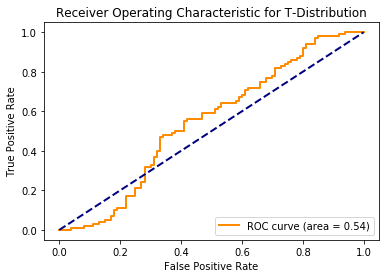

In [66]:

fpr, tpr, thresholds = metrics.roc_curve(labels,P_Roc)
roc_auc = roc_auc_score(labels,P_Roc)
plt.plot(fpr, tpr,color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for T-Distribution')
plt.legend(loc="lower right")

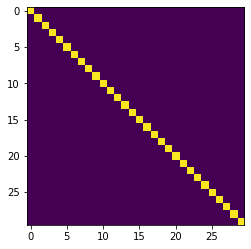

In [72]:
mean_disp = np.dot( pcaft.components_.T,np.reshape(af,(30))) + pcaft.mean_
mean_disp_new = np.array(mean_disp).astype('uint8')
mean_disp_new = np.reshape(mean_disp_new,(20,20,3))
plt.imshow(mean_disp_new)
plt.savefig('mean')
covariances = np.diag(np.diag(bf))
plt.imshow(covariances)
plt.savefig('covariance')

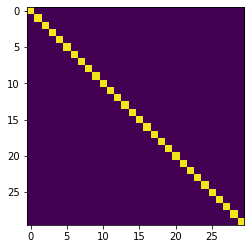

In [70]:
mean_disp = np.dot( pcanft.components_.T,np.reshape(anf,(30))) + pcanft.mean_
mean_disp_new = np.array(mean_disp).astype('uint8')
mean_disp_new = np.reshape(mean_disp_new,(20,20,3))
plt.imshow(mean_disp_new)
plt.savefig('meannf')
covariances = np.diag(np.diag(bnf))
plt.imshow(covariances)
plt.savefig('covariancenf')

In [0]:
# facetraing = []
# nonfacetraing = [] 
# facetestg = []
# nonfacetestg = []
# for i in range(1000):
#   image = np.reshape(facetrain[i],(20,20,3))
#   gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
#   facetraing.append(gray)
#   image = np.reshape(nonfacetrain[i],(20,20,3))
#   gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
#   nonfacetraing.append(gray)
# for i in range(100):
#   image = np.reshape(facetest[i],(20,20,3))
#   gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
#   facetestg.append(gray)
#   image = np.reshape(nonfacetest[i],(20,20,3))
#   gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)
#   nonfacetestg.append(gray)
# facetraing = np.array(facetraing)
# nonfacetraing = np.array(nonfacetraing)
# facetestg = np.array(facetestg)
# nonfacetestg = np.array(nonfacetestg)

In [0]:
# path = '/content/gdrive/My Drive/ECE763/'
# np.save(path+'MyData4/ftraing',np.reshape(facetraing,(1000,400)))
# np.save(path+'MyData4/nftraing',np.reshape(nonfacetraing,(1000,400)))
